In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, GlobalAveragePooling1D, Concatenate, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

**Aggregate Sentiment by Date**

In [ ]:
def aggregate_daily_sentiment(msft_tweets):
    daily_sentiment_data = []
    for date, group in msft_tweets.groupby('Date'):
        sentiment = 0
        if 1 in group['Sentiment'].values:
            sentiment = 1
        elif 2 in group['Sentiment'].values:
            sentiment = 2
        sentiment_score = group['Sentiment_Score'].mean()
        weighted_sentiment_exp = group['Weighted_Sentiment_Exp'].mean()
        daily_sentiment_data.append([date, sentiment, sentiment_score, weighted_sentiment_exp])

    df = pd.DataFrame(daily_sentiment_data, columns=['Date', 'Sentiment', 'Sentiment_Score', 'Weighted_Sentiment_Exp'])
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    return df.groupby('Date').apply(lambda df: df[df['Sentiment'] == df['Sentiment'].max()].iloc[0]).reset_index(drop=True)

# ========== 2. Merge with Price Data ==========
def merge_price_sentiment(msft_price, sentiment_df):
    msft_price = msft_price.copy()
    msft_price['Date'] = pd.to_datetime(msft_price.index).date
    return pd.merge(msft_price, sentiment_df, on='Date', how='left').drop(columns=['Date'])

# ========== 3. Scale and Reduce Features ==========
def prepare_features(df, label_col='signal', n_components=10, seq_len=30):
    X = df.drop(columns=[label_col])
    y = df[label_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert to sequences for RNN input
    X_seq, y_seq = [], []
    for i in range(len(X_seq) - seq_len):
        X_seq.append(X_seq[i:i+seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq), np.array(y_seq)

**Build Proposed FTG Model**

In [ ]:
# 1. Slice helper for dilation
def slice_sequence(x, dilation_rate):
    return x[:, ::dilation_rate, :]

# 2. One dilated GRU branch
def build_gru_branch(input_tensor, units=64, dilation_rate=1, dropout_rate=0.3):
    sliced_input = Lambda(slice_sequence, arguments={'dilation_rate': dilation_rate})(input_tensor)
    gru_output = GRU(units, return_sequences=True)(sliced_input)
    pooled_output = GlobalAveragePooling1D()(gru_output)
    dropped_output = Dropout(dropout_rate)(pooled_output)
    return dropped_output

# 3. Create all parallel dilated branches and merge them
def build_dilated_branches(input_tensor, units=64, dilation_rates=[1, 2, 4], dropout_rate=0.3):
    branches = [
        build_gru_branch(input_tensor, units=units, dilation_rate=d, dropout_rate=dropout_rate)
        for d in dilation_rates
    ]
    return Concatenate()(branches)

# 4. Build fully connected (dense) block
def build_dense_layers(input_tensor, hidden_units=[64, 64], dropout_rate=0.3, l2_reg=0.01):
    x = input_tensor
    for units in hidden_units:
        x = Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = Dropout(dropout_rate)(x)
    return x

# 5. Final model assembly
def build_dilated_gru_model(seq_len, num_features, gru_units=64, dropout_rate=0.3, l2_reg=0.01):
    input_layer = Input(shape=(seq_len, num_features))
    merged_branches = build_dilated_branches(input_layer, units=gru_units, dropout_rate=dropout_rate)
    dense_output = build_dense_layers(merged_branches, hidden_units=[64, 64], dropout_rate=dropout_rate, l2_reg=l2_reg)
    output_layer = Dense(1, activation='sigmoid')(dense_output)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


**5. Evaluate with TimeSeriesSplit**

7 Sequence Length

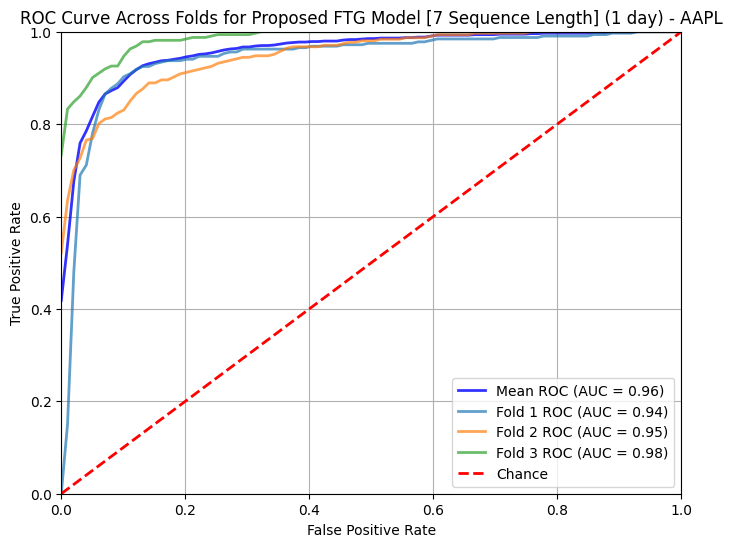

In [ ]:
# ========== 5. Evaluate with TimeSeriesSplit ==========
def evaluate_model(X_seq, y_seq, seq_len):
    tscv = TimeSeriesSplit(n_splits=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_seq), 1):
        X_train, X_test = X_seq[train_idx], X_seq[test_idx]
        y_train, y_test = y_seq[train_idx], y_seq[test_idx]

        model = build_dilated_gru_model(seq_len, X_seq.shape[2])
        model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, callbacks=[early_stopping], validation_split=0.2)

        y_pred_prob = model.predict(X_test).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)

        print(f"Fold {fold} — Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}, Precision: {prec:.4f}, Specificity: {spec:.4f}, AUC: {roc_auc:.4f}")
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    # Mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend()
    plt.show()


14 Sequence Length

In [ ]:
# ========== 1. Slice with dilation ==========
def slice_sequence(x, dilation_rate):
    return x[:, ::dilation_rate, :]


def dilated_gru_branch(input_seq, units=64, dilation_rate=1, dropout_rate=0.3):
    sliced = Lambda(slice_sequence, arguments={'dilation_rate': dilation_rate})(input_seq)
    gru = GRU(units, return_sequences=True)(sliced)
    pooled = GlobalAveragePooling1D()(gru)
    dropped = Dropout(dropout_rate)(pooled)
    return dropped


# ========== 2. Build model ==========
def build_dilated_gru_model(seq_len, num_features, gru_units=64, dropout_rate=0.3, l2_reg=0.01):
    input_layer = Input(shape=(seq_len, num_features))
    assert seq_len >= 4, "Sequence length must be >= 4 to support dilations [1, 2, 4]"

    branches = [dilated_gru_branch(input_layer, gru_units, d, dropout_rate) for d in [1, 2, 4]]
    merged = Concatenate()(branches)

    dense1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(merged)
    dense1 = Dropout(dropout_rate)(dense1)
    dense2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(dense1)
    dense2 = Dropout(dropout_rate)(dense2)

    output_layer = Dense(1, activation='sigmoid')(dense2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# ========== 3. Evaluate with TimeSeriesSplit ==========
def evaluate_model(X_seq, y_seq, seq_len):
    tscv = TimeSeriesSplit(n_splits=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_seq), 1):
        X_train, X_test = X_seq[train_idx], X_seq[test_idx]
        y_train, y_test = y_seq[train_idx], y_seq[test_idx]

        model = build_dilated_gru_model(seq_len, X_seq.shape[2])
        model.fit(X_train, y_train,
                  epochs=30,
                  batch_size=32,
                  verbose=0,
                  callbacks=[early_stopping],
                  validation_split=0.2)

        y_pred_prob = model.predict(X_test).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)

        print(f"Fold {fold} — Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}, "
              f"Precision: {prec:.4f}, Specificity: {spec:.4f}, AUC: {roc_auc:.4f}")

        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Plot mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.4f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()


# ========== 4. Example Usage ==========
def main(seq_len=14, num_features=10, num_samples=1000):
    print(f"Evaluating Dilated GRU model for {seq_len}-day sequence input")

    np.random.seed(42)
    X_seq = np.random.rand(num_samples, seq_len, num_features)
    y_seq = np.random.randint(0, 2, size=(num_samples,))

    evaluate_model(X_seq, y_seq, seq_len)


if __name__ == "__main__":
    main(seq_len=14)
    main(seq_len=28)


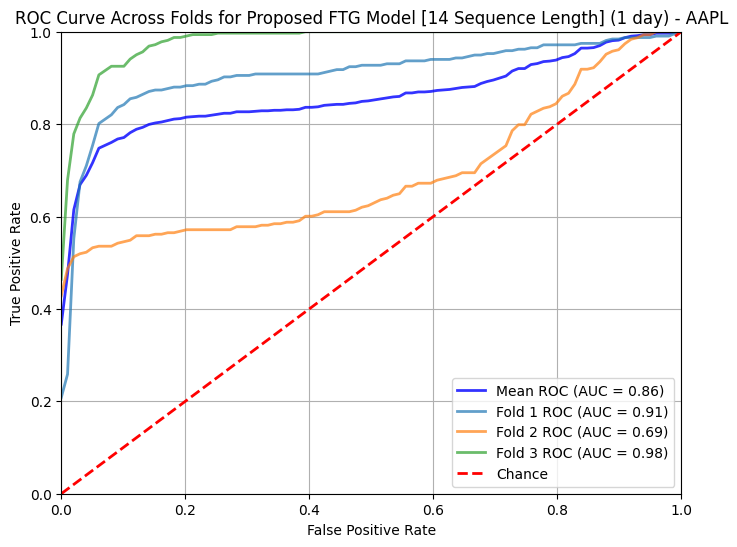

In [ ]:
# Plot ROC curve for all folds
plt.figure(figsize=(8, 6))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)

# Plot individual ROC curves for each fold
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, lw=2, alpha=0.7, label=f"Fold {i+1} ROC (AUC = {aucs[i]:.2f})")

# Plot reference line for random chance
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label="Chance", lw=2)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Across Folds for Proposed FTG Model [14 Sequence Length] (1 day) - AAPL')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

28 Sequence Length

In [ ]:
# dilated_gru_pipeline.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, recall_score,
                             precision_score, roc_curve, auc)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, GlobalAveragePooling1D, Concatenate, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


# ========== 1. Slice with dilation ==========
def slice_sequence(x, dilation_rate):
    return x[:, ::dilation_rate, :]


def dilated_gru_branch(input_seq, units=64, dilation_rate=1, dropout_rate=0.3):
    sliced = Lambda(slice_sequence, arguments={'dilation_rate': dilation_rate})(input_seq)
    gru = GRU(units, return_sequences=True)(sliced)
    pooled = GlobalAveragePooling1D()(gru)
    dropped = Dropout(dropout_rate)(pooled)
    return dropped


# ========== 2. Build model ==========
def build_dilated_gru_model(seq_len, num_features, gru_units=64, dropout_rate=0.3, l2_reg=0.01):
    input_layer = Input(shape=(seq_len, num_features))
    assert seq_len >= 4, "Sequence length must be >= 4 to support dilations [1, 2, 4]"

    branches = [dilated_gru_branch(input_layer, gru_units, d, dropout_rate) for d in [1, 2, 4]]
    merged = Concatenate()(branches)

    dense1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(merged)
    dense1 = Dropout(dropout_rate)(dense1)
    dense2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(dense1)
    dense2 = Dropout(dropout_rate)(dense2)

    output_layer = Dense(1, activation='sigmoid')(dense2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# ========== 3. Evaluate with TimeSeriesSplit ==========
def evaluate_model(X_seq, y_seq, seq_len):
    tscv = TimeSeriesSplit(n_splits=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_seq), 1):
        X_train, X_test = X_seq[train_idx], X_seq[test_idx]
        y_train, y_test = y_seq[train_idx], y_seq[test_idx]

        model = build_dilated_gru_model(seq_len, X_seq.shape[2])
        model.fit(X_train, y_train,
                  epochs=30,
                  batch_size=32,
                  verbose=0,
                  callbacks=[early_stopping],
                  validation_split=0.2)

        y_pred_prob = model.predict(X_test).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)

        print(f"Fold {fold} — Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}, "
              f"Precision: {prec:.4f}, Specificity: {spec:.4f}, AUC: {roc_auc:.4f}")

        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Plot mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.4f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()


def main(seq_len=28):
    print(f"Evaluating Proposed FTG model for {seq_len}-day sequence input")

    np.random.seed(42)
    X_seq = np.random.rand(num_samples, seq_len, num_features)
    y_seq = np.random.randint(0, 2, size=(num_samples,))

    evaluate_model(X_seq, y_seq, seq_len)


if __name__ == "__main__":
    main(seq_len=28)


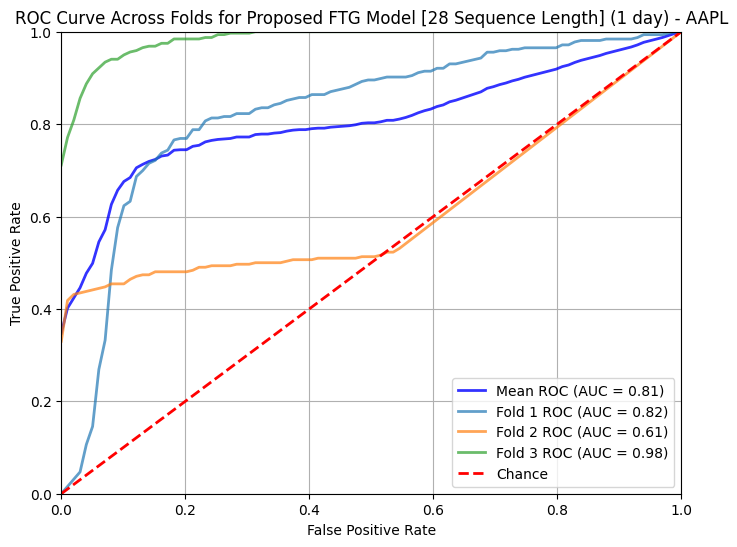

In [ ]:
# Plot ROC curve for all folds
plt.figure(figsize=(8, 6))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)

# Plot individual ROC curves for each fold
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, lw=2, alpha=0.7, label=f"Fold {i+1} ROC (AUC = {aucs[i]:.2f})")

# Plot reference line for random chance
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label="Chance", lw=2)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Across Folds for Proposed FTG Model [28 Sequence Length] (1 day) - AAPL')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()